# 2.2.Diagnostics_analysis

In [4]:
# modulos y librerías

# pandas: Librería principal para análisis y manipulación de datos.
import pandas as pd

# numpy: Biblioteca para operaciones matemáticas y manipulación de matrices y arreglos.
import numpy as np

# matplotlib.pyplot: Herramienta de visualización para crear gráficos estáticos, animados e interactivos.
import matplotlib.pyplot as plt

# seaborn: Biblioteca de visualización basada en matplotlib que proporciona una interfaz de alto nivel para dibujar gráficos estadísticos atractivos.
import seaborn as sns

# nltk: Biblioteca para trabajar con datos de lenguaje humano, incluye herramientas de tokenización, stemming, y más.
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

# gensim: Biblioteca para modelado de tópicos y vectorización de palabras, incluyendo Word2Vec.
from gensim.models import Word2Vec

# sklearn: Biblioteca para aprendizaje automático y análisis de datos. Incluye herramientas para preprocesamiento, modelado, y métricas.
from sklearn.feature_extraction.text import TfidfVectorizer
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# keras_preprocessing: Herramientas de preprocesamiento para redes neuronales, incluyendo padding para secuencias.
from keras_preprocessing.sequence import pad_sequences

# plotly: Biblioteca de visualización interactiva.
import plotly.express as px
import plotly.graph_objects as go

# time: Módulo para trabajar con tiempos, útil para medir la duración de ejecuciones.
import time

# collections: Módulo que implementa tipos de contenedores especializados (por ej. Counter para contar elementos).
import collections
from collections import Counter


In [5]:
%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [6]:
df = catalog.load('hado_final')

[09/17/23 15:11:06] INFO     Loading data from 'hado_final' (CSVDataSet)...                     data_catalog.py:345

Una vez se haya realizado la limpieza y preprocesamiento realizamos los siguientes pasos:

# 1.Vectorización de texto

La vectorización de texto es el proceso de convertir palabras en vectores numéricos que pueden ser entendidos y procesados por un algoritmo de machine learning. Existen diferentes técnicas para hacer esto, entre las que se incluyen Bag of Words, TF-IDF, y Word2Vec.

>Word2Vec es un método que utiliza redes neuronales para aprender representaciones vectoriales de palabras a partir de un corpus de texto. Este método tiene la ventaja de que puede capturar el significado semántico de las palabras.

Tenemos que convertir los diagnosticos en una lista de listas haciendo un split de la variable 
```python
diagnosticos = df['diagnosticos'].unique()`
```
Utilizaremos para los vectores
1. **Máximo**: En lugar de tomar el promedio de los vectores de palabras, puedo tomar el máximo de cada componente de los vectores de palabras. Este enfoque podría capturar la "palabra más importante" en cada dimensión del espacio vectorial.

2. **Suma**: Podría sumar los vectores de las palabras, lo que daría más peso a los diagnósticos con más palabras.

3. **Promedio**: Promediando los vectores de todas las palabras en cada diagnóstico.

4. **Concatenación**: Si el tamaño de los vectores es pequeño, podría considerarse concatenar los vectores de las palabras en lugar de promediarlos. Esto resultaría en vectores de diagnóstico más grandes, pero también podría capturar más información.

## 1.1.Stopwords

In [10]:
df\
.isna()\
.sum()

h_procedencia                 0
hospital_category             0
s_procedencia                 0
procedencia_category          0
diagnostico                   0
diagnosis_category            0
motivo_ing                    0
ingreso_category              0
motivo_alta                   0
alta_category                 0
fecha_alta                    0
ap                            0
n_estancias                   0
n_visitas                     0
paliativo_onc_noc             0
paliativo_no_onc_noc          0
fiebre                        0
disnea                        0
dolor                         0
delirium                      0
sedacion                      0
p_terminal                    0
agonia                        0
ast_anorx                     0
cronico_reag                  0
trato_antibiotico             0
transfusion                   0
paracentesis                  0
agudo_estable                 0
toracocentesis                0
fe_iv                         0
ps_ecog 

In [11]:
# Cargamos las stopwords
# from nltk.corpus import stopwords

# Descargar las stopwords de NLTK
nltk.download('stopwords')

# Obtener las stopwords en español
stopwords_es = stopwords.words('spanish')

# Aplicar la eliminación de stopwords a las columnas deseadas
columns_to_clean = ['motivo_ing', 'motivo_alta', 'diagnostico',]

for column in columns_to_clean:
    df[column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_es]))

[nltk_data] Downloading package stopwords to C:\Users\Pablo
[nltk_data]     Villar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.2.Split for list of lists

In [12]:
# Hacemos una lista de listas para poder pasar los textos a vectores

diagnosticos = df['diagnostico'].unique()

diagnosticos_split = [diagnostico.split() for diagnostico in diagnosticos]

# Filtro diagnosticos vacíos si existen... 
diagnosticos_split = [diagnostico for diagnostico in diagnosticos_split if diagnostico]

# 2.Word2Vec

Word2Vec es una técnica específica que se utiliza para el aprendizaje automático de representaciones de palabras. En esencia, convierte palabras en vectores de números de tal manera que las palabras con significados similares terminan con vectores similares. Esto permite que las operaciones matemáticas se realicen en palabras, lo que puede ser muy útil para muchas tareas de NLP.



In [14]:
# Asumiendo que los diagnósticos ya están preprocesados y almacenados en una lista de listas,
# donde cada lista interna contiene las palabras de un diagnóstico.
# Por ejemplo: [["neoplasia", "pancreas"], ["adenocarcinoma", "de", "pulmón"], ...]

# Entrenamos el modelo Word2Vec
model = Word2Vec(diagnosticos_split, min_count=1, vector_size=50)

# Ahora podemos obtener el vector de una palabra en particular
vector = model.wv['cancer']

# O incluso obtener la palabra más similar a 'neoplasia'
similar = model.wv.most_similar('cancer')

similar, vector

([('septico', 0.5110003352165222),
  ('fracturas', 0.4618563950061798),
  ('isquemicaareumatoide', 0.4074855446815491),
  ('adenocarcino', 0.39057669043540955),
  ('denencia', 0.37653809785842896),
  ('trigono', 0.37424391508102417),
  ('global', 0.3738190531730652),
  ('fragil', 0.3601739704608917),
  ('reumatoide', 0.35848185420036316),
  ('broncoaspiraciondeterioro', 0.357061505317688)],
 array([-0.00206307, -0.00134983,  0.01014814,  0.01863859, -0.02026581,
        -0.01824549,  0.01603529,  0.02281343, -0.01487547, -0.00801561,
         0.01485418, -0.00788157, -0.00617845,  0.01374094, -0.01113503,
        -0.00174002,  0.00827018,  0.00190461, -0.02161521, -0.02260242,
         0.01620434,  0.01315533,  0.01823759, -0.00120759,  0.01599858,
        -0.00570859, -0.00510819,  0.01146678, -0.01847552, -0.00714802,
        -0.01240762, -0.00207771,  0.01616402, -0.01300409, -0.00878509,
        -0.00353266,  0.01858204, -0.0101256 ,  0.00163351, -0.01220511,
        -0.01589034,  

```python
model = Word2Vec(diagnosticos_split, min_count=1, vector_size=50)
```
En `model` se está entrenando un modelo **Word2Vec** con los diagnósticos.

* La opción **min_count=1** significa que las palabras que aparecen al menos una vez en los diagnósticos serán consideradas por el modelo.

* **vector_size=50** define la dimensionalidad de los vectores de palabras generados por el modelo.
```python
model.wv['cancer']
```
* Devuelve el vector de la palabra `cancer`. Este vector es un arreglo de 50 números ***(porque se ha definido vector_size=50)*** que representa el significado de `cancer` según lo aprendido por el modelo de los diagnósticos.
```python
model.wv.most_similar('cancer')
```
* Devuelve las palabras más similares a `cancer` según lo aprendido por el modelo de los diagnósticos. La similitud se mide en términos de la similitud del coseno entre los vectores de palabras.

>**El modelo Word2Vec** necesita una gran cantidad de datos para aprender representaciones de palabras significativas. Si solo existe un pequeño número de diagnósticos, los vectores de palabras generados por el modelo podrían no ser muy significativos. En este caso, se puede considerar el uso de vectores de palabras pre-entrenados, como los disponibles en bibliotecas como spaCy o gensim.

## 2.1.Gensim

Gensim es una biblioteca de Python muy popular para el modelado de temas y el procesamiento del lenguaje natural (NLP). Proporciona implementaciones eficientes y escalables de varios algoritmos de NLP, como Word2Vec, FastText, Latent Semantic Analysis (LSA), Latent Dirichlet Allocation (LDA) y otros.

Gensim es una opción popular para usar Word2Vec por varias razones:

1. **Eficiencia**: Gensim está diseñado para ser eficiente y para manejar grandes conjuntos de datos. Utiliza técnicas como la transmisión de datos y la segmentación de memoria para mantener una huella de memoria baja.

2. **Facilidad de uso**: Gensim proporciona una interfaz simple y directa para el uso de algoritmos de NLP complejos como Word2Vec.

3. **Flexibilidad**: Gensim permite un control detallado sobre los parámetros de los modelos, lo que puede ser útil para ajustar el rendimiento del modelo para tareas específicas.

4. **Comunidad de apoyo**: Gensim es una biblioteca muy utilizada con una gran comunidad de usuarios y desarrolladores. Esto significa que hay una gran cantidad de documentación, tutoriales y soporte disponible.

En cuanto a por qué Word2Vec y Gensim son buenas elecciones para el análisis de diagnósticos médicos, hay varias razones. 

* Los diagnósticos médicos a menudo contienen términos y frases muy específicos, y Word2Vec puede ser útil para capturar las similitudes semánticas entre estos términos. 
  
* Gensim es una opción práctica porque permite un manejo eficiente de grandes conjuntos de datos, que a menudo se encuentran en aplicaciones médicas. 
  
* Por último, la capacidad de Gensim para ajustar detalladamente los parámetros del modelo puede ser útil para afinar el rendimiento del modelo en el análisis de diagnósticos médicos.


## 2.2.Enfoque TF-IDF

No todos los diagnósticos tendrán el mismo número de palabras, y algunos diagnósticos pueden tener palabras que son más importantes que otras para determinar el significado del diagnóstico. En estos casos, tomar el promedio de los vectores de palabras puede no ser la mejor representación.

Una opción es usar un enfoque más sofisticado como TF-IDF (Term Frequency-Inverse Document Frequency) para dar más peso a las palabras que son más importantes en un diagnóstico y menos peso a las palabras que son comunes en muchos diagnósticos.

> Pero, en muchos casos, palabras comunes como "cancer" o "infeccion" son de hecho muy importantes para el diagnóstico, y el enfoque TF-IDF puede darles menos peso porque son comunes.

> En general, la decisión de utilizar `CountVectorizer` frente a `TfidfVectorizer` depende del problema específico y del conjunto de datos. Si las palabras comunes en los diagnósticos tienen un significado significativo, entonces `CountVectorizer` podría ser una buena opción. De lo contrario, `TfidfVectorizer` podría ser más apropiado, ya que reduce la ponderación de las palabras que aparecen con frecuencia en el corpus.

In [15]:
start_time = time.time()

# Convertimos los diagnósticos a cadenas de texto para usar con TfidfVectorizer
diagnosticos_str = [' '.join(diagnostico) for diagnostico in diagnosticos_split]

# Entrenamos el modelo Word2Vec
model = Word2Vec(diagnosticos_split, min_count=10, vector_size=50)

# Creamos un diccionario para mapear cada palabra a su vector Word2Vec
word_to_vec = {word: model.wv[word] for word in model.wv.key_to_index.keys()}

# Crea un vectorizador TF-IDF, limitando el vocabulario a las palabras que están en el modelo Word2Vec
vectorizer = TfidfVectorizer(vocabulary=model.wv.key_to_index)

# Calcula los vectores TF-IDF para los diagnósticos
tfidf = vectorizer.fit_transform(diagnosticos_str)

# Ahora podemos obtener el vector TF-IDF para cada diagnóstico
diagnosticos_vec = []
for i in range(tfidf.shape[0]):
    tfidf_diag = tfidf.getrow(i)
    diag_vec = np.mean([word_to_vec[word] * tfidf_diag[0, vectorizer.vocabulary_[word]] 
                        for word in diagnosticos_split[i] if word in word_to_vec], axis=0)
    diagnosticos_vec.append(diag_vec)

end_time = time.time()
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time} segundos")

[09/17/23 15:16:25] WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\sklearn\feature_extr                
                             action\text.py:1380: UserWarning:                                                     
                                                                                                                   
                             Upper case characters found in vocabulary while 'lowercase' is True.                  
                             These entries will not be matched with any documents                                  
                                                                                                                   
                                                                                                                   

                    WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\numpy\core\fromnumer                
                             ic.py:3432: RuntimeWarning:                                                           
                                                                                                                   
                             Mean of empty slice.                                                                  
                                                                                                                   
                                                                                                                   

                    WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\numpy\core\_methods.                
                             py:190: RuntimeWarning:                                                               
                                                                                                                   
                             invalid value encountered in double_scalars                                           
                                                                                                                   
                                                                                                                   

Tiempo de ejecución: 0.10515642166137695 segundos


In [16]:
diagnosticos_vec[0]

array([-0.00096134,  0.00022872,  0.00970196,  0.01877245, -0.01895286,
       -0.01512672,  0.01442404,  0.01965428, -0.01136049, -0.00878728,
        0.01474242, -0.00484182, -0.00856008,  0.0140835 , -0.01030294,
       -0.00257145,  0.0068383 ,  0.00298405, -0.01824179, -0.02034889,
        0.01590384,  0.01112068,  0.01537736,  0.00131451,  0.01320184,
       -0.00648203, -0.00171075,  0.01270794, -0.01593615, -0.00709497,
       -0.01554394, -0.00285595,  0.01959155, -0.01536676, -0.00566468,
       -0.00362504,  0.01783465, -0.01196974, -0.00020377, -0.00902171,
       -0.018208  ,  0.00956227, -0.01797005, -0.00842523,  0.00156658,
       -0.00084077, -0.01610698,  0.01836316,  0.01070216,  0.01962696],
      dtype=float32)

# 3.EDA Vectores 

1. **Calcular y graficar la longitud de los vectores**: La longitud (o norma) de un vector puede ser una característica interesante a explorar. Puede calcularse la longitud de un vector usando la función `np.linalg.norm`

2. **Visualizar los vectores con PCA**: Puede usarse el Análisis de Componentes Principales (PCA) para reducir la dimensionalidad de los vectores a 2 o 3 dimensiones, y luego visualizarlos en un gráfico de dispersión.

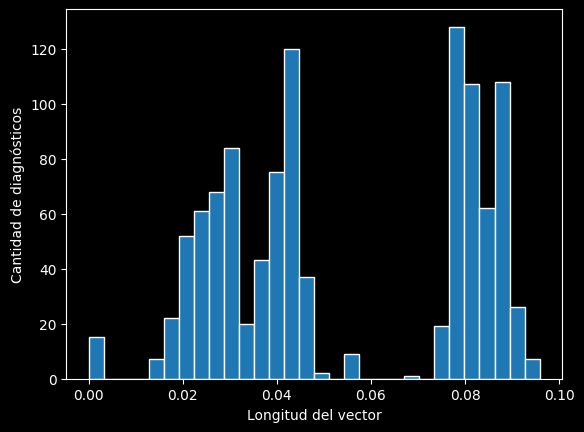

In [17]:
# Calcular y graficar la longitud de los vectores

# Calcula la longitud de cada vector
vector_lengths = [np.linalg.norm(vec) for vec in diagnosticos_vec]

# Grafica un histograma de las longitudes
plt.hist(vector_lengths, bins=30, color='tab:blue', edgecolor='white')
plt.xlabel('Longitud del vector')
plt.ylabel('Cantidad de diagnósticos')
plt.show();

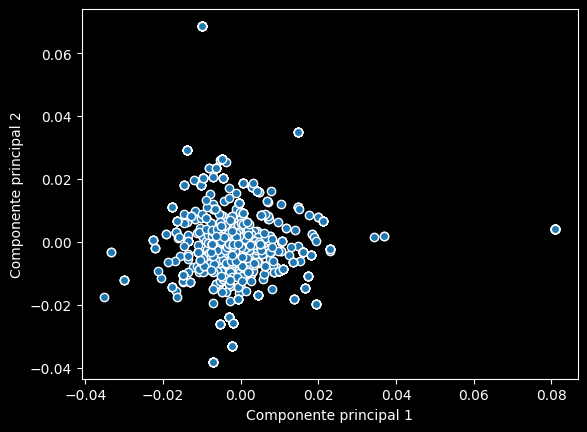

In [19]:
# Visualizar los vectores con PCA

# Vectores con la misma longitud
diagnosticos_vec = []
for i in range(tfidf.shape[0]):
    tfidf_diag = tfidf.getrow(i)
    words_vecs = [word_to_vec[word] * tfidf_diag[0, vectorizer.vocabulary_[word]] 
                  for word in diagnosticos_split[i] if word in word_to_vec]
    if words_vecs:
        diag_vec = np.mean(words_vecs, axis=0)
    else:
        diag_vec = np.zeros(model.vector_size)  # reemplaza vectores vacíos por vectores de ceros
    diagnosticos_vec.append(diag_vec)
    
# Reduce la dimensionalidad a 2
pca = PCA(n_components=2)
diagnosticos_pca = pca.fit_transform(diagnosticos_vec)

# Grafica los vectores en 2D
plt.scatter(diagnosticos_pca[:, 0], diagnosticos_pca[:, 1], c='tab:blue', edgecolors='white')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.show()

In [20]:
# Reduce la dimensionalidad a 3
pca = PCA(n_components=3)
diagnosticos_pca = pca.fit_transform(diagnosticos_vec)

# Crea el gráfico de dispersión 3D
fig = go.Figure(data=[go.Scatter3d(
    x=diagnosticos_pca[:, 0],
    y=diagnosticos_pca[:, 1],
    z=diagnosticos_pca[:, 2],
    mode='markers',
    marker=dict(
        size=6,
        color=diagnosticos_pca[:, 2],   # utiliza la tercera componente para el color
        colorscale='Viridis',            # elige una escala de colores
        opacity=0.8
    )
)])

# Actualiza los ejes del gráfico
fig.update_layout(
    scene = dict(
        xaxis_title='Componente principal 1',
        yaxis_title='Componente principal 2',
        zaxis_title='Componente principal 3',
        aspectmode='cube'                # hace que los ejes tengan la misma escala
    ),
    margin=dict(l=0, r=0, b=0, t=0),    # elimina los márgenes alrededor del gráfico
    scene_camera=dict(eye=dict(x=1.5, y=1.5, z=0.8))   # ajusta la posición inicial de la cámara
)

fig.show()

# la opción aspectmode='cube' es para hacer que los ejes tengan la misma escala,
# lo que puede hacer que la visualización sea más fácil de interpretar.

# 4.Calculo los Vectores

## 4.1.Máximo (toma el valor máximo de cada dimensión a través de todas las palabras en el diagnóstico)


In [21]:
diagnosticos_vec_max = [np.max([model.wv[word] for word in diagnostico if word in model.wv.key_to_index], axis=0) 
                        if diagnostico and any(word in model.wv.key_to_index for word in diagnostico)
                        else np.zeros(model.vector_size) 
                        for diagnostico in diagnosticos_split]

In [26]:
# Entonces podemos entrenar un modelo KMeans en estos vectores.
kmeans = KMeans(n_clusters=3, n_init='auto')  # Ajusta este número a la cantidad de grupos que creas adecuada
kmeans.fit(diagnosticos_vec_max)

# Ahora podemos obtener las etiquetas de los grupos para cada diagnóstico
labels = kmeans.labels_

# PCA
pca = PCA(n_components=2)
diagnosticos_vec_max_pca = pca.fit_transform(diagnosticos_vec_max)

diagnosticos_vec_max_pca

array([[-0.02702469,  0.07837364],
       [-0.02795954, -0.00851689],
       [-0.02702469,  0.07837364],
       ...,
       [-0.02795954, -0.00851689],
       [-0.02795954, -0.00851689],
       [-0.02795954, -0.00851689]])

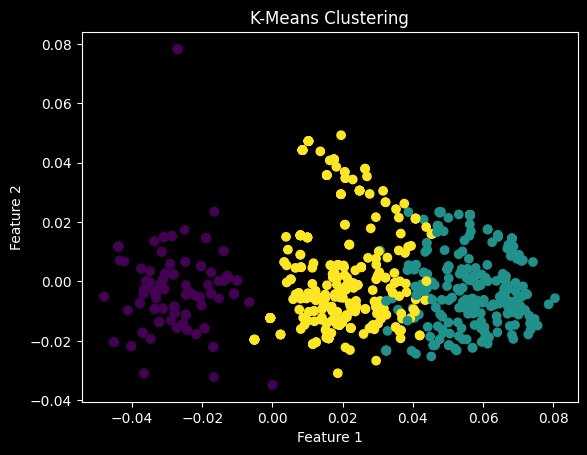

In [72]:
# Visualize the clusters:
plt.scatter(diagnosticos_vec_max_pca[:, 0], diagnosticos_vec_max_pca[:, 1], c=kmeans.labels_)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Clustering')
plt.show();

In [31]:
def kmeans_pca(vector, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto') 
    kmeans.fit(vector)

    labels = kmeans.labels_

    # PCA
    pca = PCA(n_components=2)
    vector_pca = pca.fit_transform(vector)
    # Visualize the clusters:
    plt.scatter(vector_pca[:, 0], vector_pca[:, 1], c=kmeans.labels_)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('K-Means Clustering')
    plt.show();

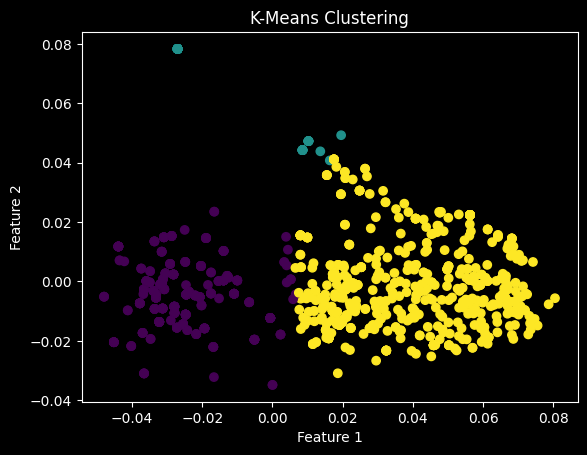

In [71]:
kmeans_pca(diagnosticos_vec_max)

## 4.2.Suma (suma los vectores de todas las palabras en el diagnóstico)

In [74]:
diagnosticos_vec_sum = [np.sum([model.wv[word] for word in diagnostico if word in model.wv.key_to_index], axis=0) 
                        if diagnostico and any(word in model.wv.key_to_index for word in diagnostico)
                        else np.zeros(model.vector_size) 
                        for diagnostico in diagnosticos_split]

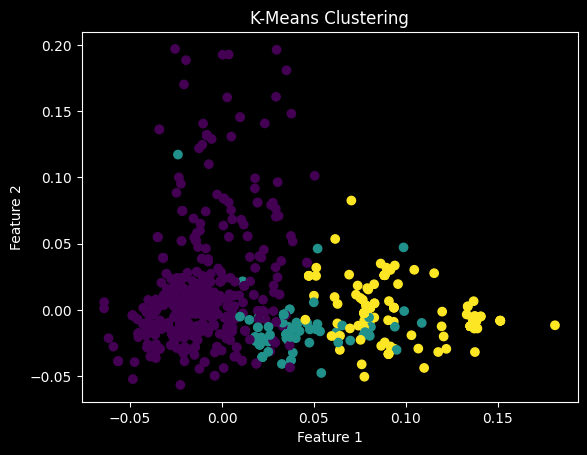

In [77]:
kmeans_pca(diagnosticos_vec_sum)

## 4.3.Promedio (promediando los vectores de todas las palabras en cada diagnóstico)

In [78]:
diagnosticos_vec_mean = [np.mean([model.wv[word] for word in diagnostico if word in model.wv.key_to_index], axis=0) 
                        if diagnostico and any(word in model.wv.key_to_index for word in diagnostico)
                        else np.zeros(model.vector_size) 
                        for diagnostico in diagnosticos_split]

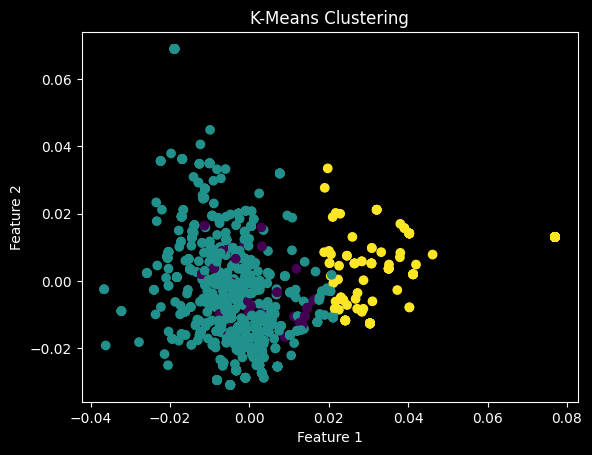

In [81]:
kmeans_pca(diagnosticos_vec_mean)

## 4.4.Concatenación (concatena los vectores de todas las palabras en el diagnóstico)

Este método requerirá que todas las listas de diagnósticos tengan la misma longitud (es decir, el mismo número de palabras). Si no es así, tendrás que rellenar las listas más cortas con algún valor (como un vector de ceros).

> Este último método puede resultar en vectores muy largos si los diagnósticos contienen muchas palabras, lo que puede hacer que los modelos de aprendizaje automático sean más difíciles de entrenar.

In [82]:
# Asumimos que 'max_len' es la longitud del diagnóstico más largo en 'diagnosticos_split'
max_len = max([len(diagnostico) for diagnostico in diagnosticos_split])

diagnosticos_pad = pad_sequences(diagnosticos_split, maxlen=max_len, dtype='object', padding='post')
'''pad_sequences se utiliza para garantizar que todas las secuencias (en este caso, listas de vectores de palabras) 
tengan la misma longitud añadiendo "relleno" según sea necesario. Este relleno se hace con vectores de ceros, 
que son de tipo float32, para que coincidan con el tipo de datos de los vectores de palabras existentes.'''

diagnosticos_vec_concat = [np.concatenate([model.wv[word] if word in model.wv.key_to_index else np.zeros(model.vector_size) for word in diagnostico]) for diagnostico in diagnosticos_pad]

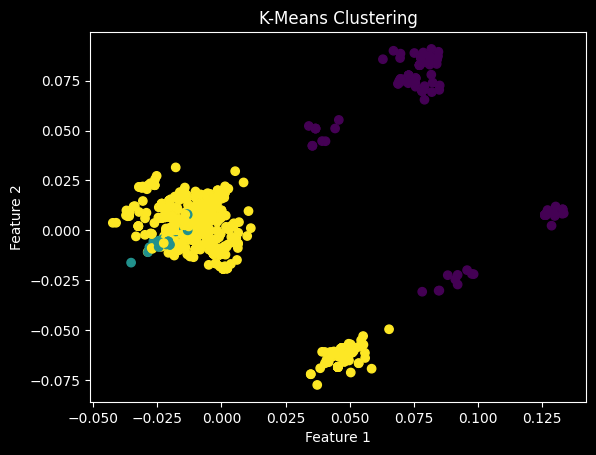

In [94]:
kmeans_pca(diagnosticos_vec_concat)

>Ahora que tenemos los vectores de diagnóstico (ya sea máximo, suma, promedio o concatenación), pueden usarse como entrada para un algoritmo de aprendizaje automático o análisis de datos. Por ejemplo, estos vectores pueden alimentar a un algoritmo de clustering para agrupar diagnósticos similares, o a un algoritmo de clasificación para predecir alguna etiqueta basada en el texto del diagnóstico.

# Funciones

> Cuando tenemos un modelo Word2Vec `model` y una lista de diagnósticos divididos en palabras `data_split` podemos realizar estas funciones

Estas funciones realizan los siguientes pasos:
<hr>

* **create_vectors**: Crea vectores para los diagnósticos utilizando el método especificado (máximo, suma, media).

* **cluster_diagnosticos**: Aplica el algoritmo KMeans a los vectores de los diagnósticos.

* **create_clusters**: Crea un diccionario donde las llaves son las etiquetas de los clusters y los valores son las listas de diagnósticos que pertenecen a cada cluster.

* **print_clusters**: Imprime los diagnósticos en cada cluster.

* **print_top_words**: Imprime las palabras más comunes en cada cluster.
<hr>

* Código:
````python
import numpy as np
from sklearn.cluster import KMeans
import collections

def create_vectors(model, data_split, method='mean'):
    if method == 'max':
        data_vec = [np.max([model.wv[word] for word in data_item], axis=0) 
                            if data_item else np.zeros(model.vector_size) 
                            for data_item in data_split]
    elif method == 'sum':
        data_vec = [np.sum([model.wv[word] for word in text if word in model.wv.vocab], axis=0) 
                    for text in data_split]
        
    elif method == 'mean':
        data_vec = [np.mean([model.wv[word] for word in data_item], axis=0) 
                            if data_item else np.zeros(model.vector_size) 
                            for data_item in data_split]
    return data_vec

def cluster_data(data_vec, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data_vec)
    labels = kmeans.labels_
    return labels

def create_clusters(data_split, labels, n_clusters=5):
    clusters = {i: [] for i in range(n_clusters)}
    for data_item, label in zip(data_split, labels):
        clusters[label].append(' '.join(data_item))
    return clusters

def print_clusters(clusters):
    for label, data_items in clusters.items():
        print(f'Cluster {label}:')
        for data_item in data_items:
            print(f'  {data_item}')

def print_top_words(clusters, n_words=10):
    for label, data_items in clusters.items():
        words = [word for data_item in data_items for word in data_item.split()]
        word_counts = collections.Counter(words)
        print(f'Cluster {label}:')
        for word, count in word_counts.most_common(n_words):
            print(f'  {word}: {count}')

````



In [102]:
# Genérico

def create_vectors(model, data_split, method='mean'):
    if method == 'max':
        data_vec = [np.max([model.wv[word] for word in data_item if word in model.wv.key_to_index], axis=0) 
                            if any(word in model.wv.key_to_index for word in data_item) else np.zeros(model.vector_size) 
                            for data_item in data_split]
    elif method == 'sum':
        data_vec = [np.sum([model.wv[word] for word in data_item if word in model.wv.key_to_index], axis=0) 
                            if any(word in model.wv.key_to_index for word in data_item) else np.zeros(model.vector_size) 
                            for data_item in data_split]
    elif method == 'mean':
        data_vec = [np.mean([model.wv[word] for word in data_item if word in model.wv.key_to_index], axis=0) 
                            if any(word in model.wv.key_to_index for word in data_item) else np.zeros(model.vector_size) 
                            for data_item in data_split]
        
    elif method == 'concat':
        max_len = max([len(data_item) for data_item in data_split])
        data_split_pad = pad_sequences(data_split, maxlen=max_len, dtype='object', padding='post')
        data_vec = [np.concatenate([model.wv[word] if word in data_item else np.zeros(model.vector_size) for word in data_item]) 
                    for data_item in data_split_pad]

    return data_vec

def cluster_data(data_vec, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    kmeans.fit(data_vec)
    labels = kmeans.labels_
    return labels

def create_clusters(data_split, labels, n_clusters=5):
    clusters = {i: [] for i in range(n_clusters)}
    for data_item, label in zip(data_split, labels):
        clusters[label].append(' '.join(data_item))
    return clusters

def print_clusters(clusters):
    for label, data_items in clusters.items():
        print(f'Cluster {label}:')
        for data_item in data_items:
            print(f'  {data_item}')

def print_top_words(clusters, n_words=10):
    for label, data_items in clusters.items():
        words = [word for data_item in data_items for word in data_item.split()]
        word_counts = collections.Counter(words)
        print(f'Cluster {label}:')
        for word, count in word_counts.most_common(n_words):
            print(f'  {word}: {count}')

# Resumen


Los vectores que se han generado representan la semántica de los diagnósticos médicos en un espacio de características numéricas. Ahora pueden aplicarse una variedad de técnicas de aprendizaje automático y análisis de datos para explorar y hacer predicciones basadas en estos vectores. Por ejemplo:

1. **Agrupación (Clustering)**: Podrían usarse algoritmos de clustering como K-means, DBSCAN, o Agglomerative Clustering para agrupar diagnósticos similares. Esto puede ser útil para descubrir grupos de diagnósticos que son semánticamente similares.

2. **Reducción de dimensionalidad y visualización**: Podrían usarse técnicas de reducción de dimensionalidad como PCA, t-SNE, o UMAP para visualizar tus datos en 2D o 3D. Esto puede ayudar a entender la estructura y las relaciones entre los diagnósticos.

3. **Clasificación**: Si existen etiquetas para los diagnósticos (por ejemplo, si se sabe a qué categoría de enfermedad pertenece cada diagnóstico), podría entrenarse un modelo de clasificación para predecir estas etiquetas. Algunos algoritmos que podrían considerarse incluyen regresión logística, máquinas de vectores de soporte (SVM), árboles de decisión, y redes neuronales.

4. **Regresión**: Si hay una variable objetivo continua (por ejemplo, la duración del tratamiento o el costo del tratamiento), podría entrenarse un modelo de regresión para predecir esta variable basándote en el diagnóstico.

5. **Análisis de sentimientos**: Aunque los diagnósticos médicos no suelen tener un "sentimiento" en el mismo sentido que las reseñas de productos o los tweets, podría ser interesante explorar si ciertas palabras o frases están asociadas con resultados más positivos o negativos.

* **Creación de vectores**: Utiliza la función `create_vectors` para transformar los datos de texto en vectores. Esta función requiere el modelo de incrustación de palabras (en este caso, un modelo Word2Vec entrenado con Gensim) y los datos de texto que se desean transformar. Además, puede especificarse un método para combinar las incrustaciones de palabras individuales en una sola incrustación por documento (por ejemplo, sumando o promediando las incrustaciones de palabras).

````python
# Para el método 'sum'
data_split = diagnosticos_split
data_vec_sum = create_vectors(model, data_split, method='sum')
````
* **Clustering**: Una vez que se tienen los datos en forma vectorial, puede utilizarse cualquier algoritmo de clustering. En este caso, se está utilizando KMeans de la biblioteca scikit-learn. Necesitará especificarse el número de clusters que se desea (en este caso, 5).
````python
labels_sum = cluster_data(data_vec_sum, n_clusters=5)
````

* **Creación de clusters**: Después de realizar el clustering, pueden organizarse los datos originales en clusters de acuerdo con las etiquetas de cluster que se han obtenido.
````python
clusters_sum = create_clusters(data_split, labels_sum, n_clusters=5)
````

* **Visualización de resultados**: Finalmente, pueden imprimirse los resultados de los clusters y mostrar las palabras más comunes en cada cluster.
````python
print_clusters(clusters_sum)

print_top_words(clusters_sum)
````



# 5.Clustering (Agupación)

In [108]:
# Hacemos una lista de listas para poder pasar los textos a vectores

diagnosticos = df['diagnostico'].unique()

diagnosticos_split = [diagnostico.split() for diagnostico in diagnosticos]

# Filtro diagnosticos vacíos si existen... 
diagnosticos_split = [diagnostico for diagnostico in diagnosticos_split if diagnostico]

model = Word2Vec(diagnosticos_split, min_count=1, vector_size=50)

In [109]:
data_vec_mean = create_vectors(model=model, data_split=diagnosticos_split, method='mean')
labels_mean = cluster_data(data_vec=data_vec_mean, n_clusters=5)
cluster_mean = create_clusters(data_split=diagnosticos_split, labels=labels_mean, n_clusters=5)
print_top_words(clusters=cluster_mean, n_words=5)

Cluster 0:
  cirrosisencefalopatia: 1
Cluster 1:
  cancer: 185
  estadio: 125
  IV: 125
  pulmon: 29
  colon: 28
Cluster 2:
  demencia: 30
  respiratoria: 22
  ulceras: 20
  epoc: 17
  cirrosis: 15
Cluster 3:
  insuficiencia: 62
  cardiaca: 49
  cronica: 46
  neoplasia: 42
  cognitivo: 40
Cluster 4:
  infeccion: 68
  fragil: 23
  sindrome: 22
  urinaria: 19
  aguda: 18


In [105]:
data_vec_max = create_vectors(model=model, data_split=diagnosticos_split, method='max')
labels_max = cluster_data(data_vec=data_vec_max, n_clusters=5)
cluster_max = create_clusters(data_split=diagnosticos_split, labels=labels_max, n_clusters=5)
print_top_words(clusters=cluster_max, n_words=5)

Cluster 0:
  anemia: 1
  niemannpick: 1
  sdown: 1
  ITU: 1
  smd: 1
Cluster 1:
  IV: 140
  estadio: 136
  cancer: 93
  insuficiencia: 65
  infeccion: 61
Cluster 2:
  acv: 2
  aguda: 2
  hepatocarcinoma: 2
  neumonia: 1
  sarcoidosis: 1
Cluster 3:
  cancer: 103
  epidermoide: 10
  colon: 9
  pulmon: 7
  prostata: 4
Cluster 4:
  infeccion: 41
  neoplasia: 27
  carcinoma: 23
  respiratoria: 22
  ulcera: 17


In [107]:
data_vec_sum = create_vectors(model=model, data_split=diagnosticos_split, method='sum')
labels_sum = cluster_data(data_vec=data_vec_sum, n_clusters=5)
cluster_sum = create_clusters(data_split=diagnosticos_split, labels=labels_sum, n_clusters=5)
print_top_words(clusters=cluster_sum, n_words=5)

Cluster 0:
  IV: 135
  estadio: 128
  cancer: 49
  neoplasia: 20
  colon: 17
Cluster 1:
  neoplasia: 37
  demencia: 33
  ulceras: 29
  ulcera: 25
  sindrome: 22
Cluster 2:
  infeccion: 86
  respiratoria: 26
  ITU: 22
  urinaria: 17
  cognitivo: 7
Cluster 3:
  cancer: 144
  deterioro: 29
  cognitivo: 28
  pulmon: 18
  epidermoide: 16
Cluster 4:
  insuficiencia: 66
  cardiaca: 52
  cronica: 38
  renal: 11
  infeccion: 10


# Proceso de Clustering desglosado:

In [110]:
# Primero, necesitamos convertir nuestros diagnósticos a vectores.
# Podemos hacer esto promediando los vectores de todas las palabras en cada diagnóstico.
diagnosticos_vec = []
for diagnostico in diagnosticos_split:
    vec = [model.wv[word] for word in diagnostico if word in model.wv.key_to_index]
    if vec:  # Verificar que la lista no esté vacía
        diagnosticos_vec.append(np.mean(vec, axis=0))
    else:  # Si la lista está vacía, agregar un vector de ceros
        diagnosticos_vec.append(np.zeros((model.vector_size,)))

# Convertimos la lista en un array de numpy para asegurar que el formato sea correcto
diagnosticos_vec = np.array(diagnosticos_vec)

# Entonces podemos entrenar un modelo KMeans en estos vectores.
kmeans = KMeans(n_clusters=3, n_init='auto')  # Ajusta este número a la cantidad de grupos que creas adecuada
kmeans.fit(diagnosticos_vec)

# Ahora podemos obtener las etiquetas de los grupos para cada diagnóstico
labels = kmeans.labels_

In [111]:
# Crea un diccionario donde las llaves son las etiquetas del cluster y los valores son listas de diagnósticos pertenecientes a ese cluster
clusters = {i: [] for i in range(3)}  # Asegúrate de cambiar el rango para que coincida con el número de clusters que estás usando

for diagnostico, label in zip(diagnosticos_split, labels):
    clusters[label].append(' '.join(diagnostico))

# Ahora puedes imprimir los diagnósticos en cada cluster
for label, diagnosticos in clusters.items():
    print(f'Cluster {label}:')
    for diagnostico in diagnosticos:
        print(f'  {diagnostico}')


Cluster 0:
  neoplasia mama estadio IV
  adenoma pulmon
  fx meseta tibial
  deterioro general
  tumor cerebral
  adenoma colon IV
  sarcoidosis
  sdown
  demencia fallo multiorganico
  ITU
  ulceras mmii
  ulceras vasculares
  hsa
  deterioro cognitivo
  miocardiopatia hipertrofica
  masa abdominal
  fa valvulopatia aortica insuficiencia cardiaca
  carcinoma epidermoide labio
  ITU asintomatica
  endocarditis
  isquemia eeii
  sepsis urinaria
  tratamiento antibiotico IV
  demencia
  bronquiectasias
  insuficiencia cardiaca
  carcinoma sigma
  ulcera mid
  anciano fragil
  adenocarcino colon estadio IV
  deterioro general trastorno metabolico
  neo colon
  adenocarcinoma ovario estadio IV
  hepatocarcinoma estadio IV
  deterioro cogitivo grave
  anoxia cerebral
  deterioro cognitivo neumonia
  gastroenteritis
  neoplasia rectosepsi urinaria
  insuficiencia cardiaca descompensada
  deterioro cognitivo avanzado
  masa abdominal anexial
  esquizofreniaanciano fragil
  enfermedad charcot


In [112]:
for diagnostico, label in zip(diagnosticos_split, labels):
    clusters[label].append(' '.join(diagnostico))
    
    '''Estás iterando sobre tus diagnósticos y sus etiquetas de cluster correspondientes. 
    Para cada diagnóstico, transformas la lista de palabras en una cadena de texto (usando ' '.join(diagnostico)) 
    y la añades a la lista correspondiente en el diccionario clusters.
    
    Por ejemplo, si tienes un diagnóstico que es ["neoplasia", "pancreas"] y su etiqueta de cluster es 2,
    este diagnóstico se transformaría en la cadena de texto "neoplasia pancreas" y se añadiría a la lista de diagnósticos
    del cluster 2 en el diccionario clusters. Así, al final, tendrías un diccionario donde para cada cluster, 
    tienes una lista de todos los diagnósticos (como cadenas de texto) que pertenecen a ese cluster'''

También se pueden investigar las palabras más representativas de cada cluster. Esto puede darte una idea de las características que el modelo está utilizando para distinguir entre los diferentes clusters.

In [113]:
# Para cada cluster, encuentra las 10 palabras más comunes
for label, diagnosticos in clusters.items():
    # Juntamos todos los diagnósticos en una sola lista de palabras
    palabras = [palabra for diagnostico in diagnosticos for palabra in diagnostico.split()]
    
    # Contamos las ocurrencias de cada palabra
    conteo_palabras = collections.Counter(palabras)
    
    print(f'Cluster {label}:')
    for palabra, conteo in conteo_palabras.most_common(10):
        print(f'  {palabra}: {conteo}')

Cluster 0:
  IV: 208
  estadio: 196
  insuficiencia: 124
  neoplasia: 120
  cardiaca: 94
  cognitivo: 80
  deterioro: 74
  cronica: 70
  ulcera: 62
  ulceras: 60
Cluster 1:
  cancer: 348
  IV: 82
  estadio: 76
  epidermoide: 34
  colon: 32
  pulmon: 28
  gastrico: 20
  prostata: 18
  pancreas: 12
  vejiga: 10
Cluster 2:
  infeccion: 164
  respiratoria: 64
  sindrome: 44
  demencia: 42
  aguda: 34
  epoc: 32
  leucemia: 30
  urinaria: 30
  absceso: 30
  cronica: 28


# 6.PCA

In [130]:
# Reducir la dimensionalidad de los vectores a 2 dimensiones con PCA:

pca = PCA(n_components=2)
data_vec_mean_pca = pca.fit_transform(data_vec_mean)

# Crear un DataFrame de pandas con las coordenadas 2D y las etiquetas de los clusters:
df_pca = pd.DataFrame(data_vec_mean_pca, columns=['x', 'y'])
df_pca['cluster'] = labels_mean

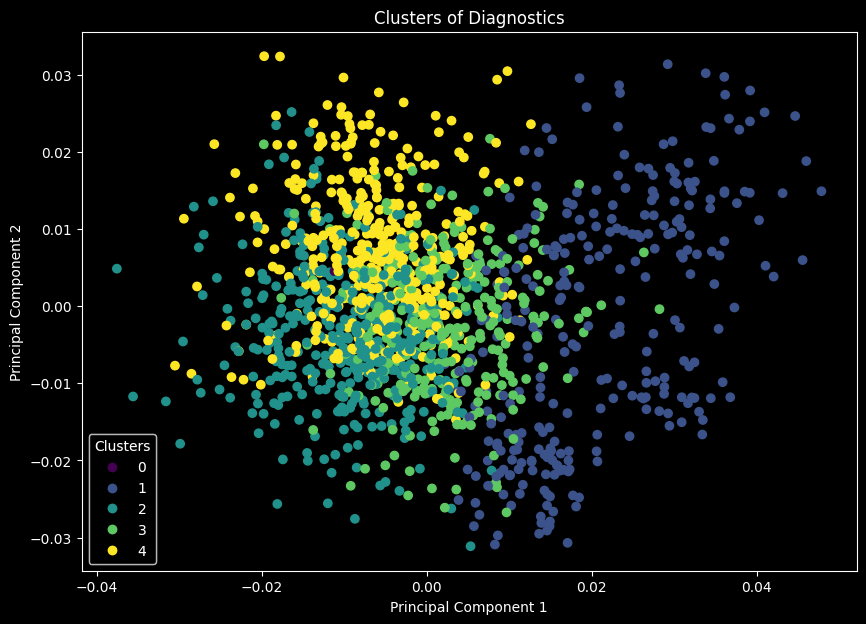

In [131]:
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(df_pca['x'], df_pca['y'], c=df_pca['cluster'], cmap='viridis')
ax.set_title('Clusters of Diagnostics')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# create legend as per color map
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
ax.add_artist(legend1)

plt.show()

In [132]:
# Visualizar los clusters con Plotly:
fig = px.scatter(df_pca, x='x', y='y', color='cluster', width=800, height=600)
fig.update_traces(marker=dict(size=6))
fig.show()

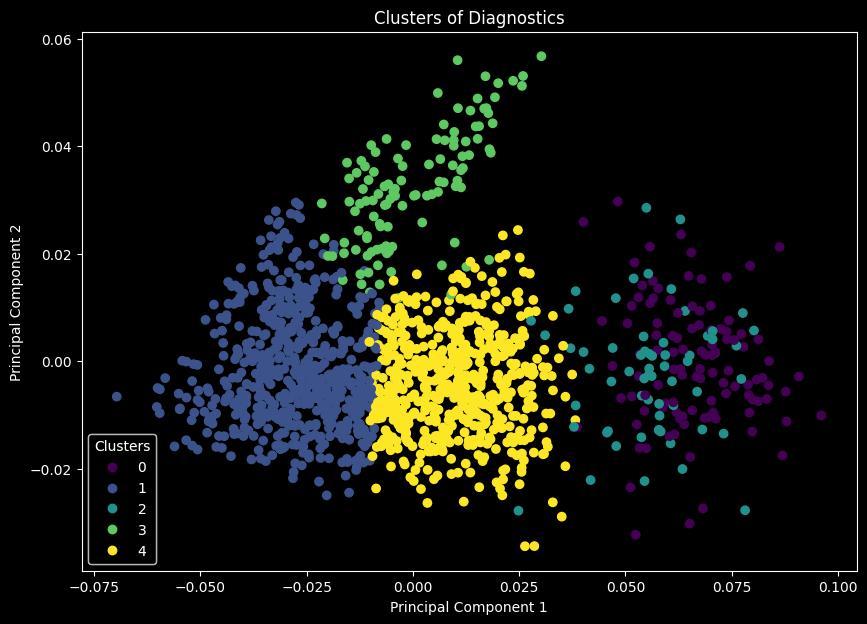

In [133]:
pca = PCA(n_components=2)
data_vec_max_pca = pca.fit_transform(data_vec_max)

df_pca_max = pd.DataFrame(data_vec_max_pca, columns=['x', 'y'])
df_pca_max['cluster'] = labels_max

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(df_pca_max['x'], df_pca_max['y'], c=df_pca_max['cluster'], cmap='viridis')
ax.set_title('Clusters of Diagnostics')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# create legend as per color map
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
ax.add_artist(legend1)

plt.show()

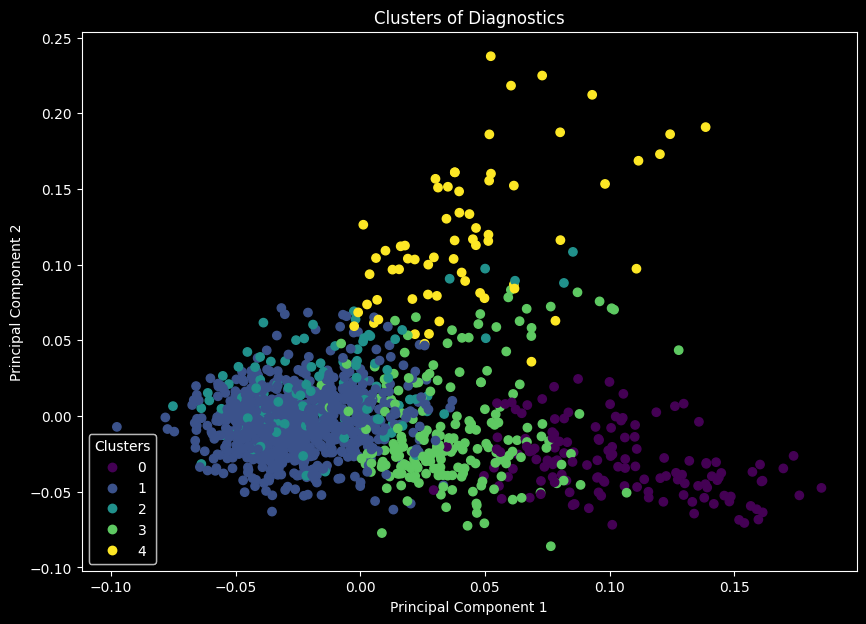

In [135]:
pca = PCA(n_components=2)
data_vec_sum_pca = pca.fit_transform(data_vec_sum)

df_pca_sum = pd.DataFrame(data_vec_sum_pca, columns=['x', 'y'])
df_pca_sum['cluster'] = labels_sum

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(df_pca_sum['x'], df_pca_sum['y'], c=df_pca_sum['cluster'], cmap='viridis')
ax.set_title('Clusters of Diagnostics')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# create legend as per color map
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
ax.add_artist(legend1)

plt.show()

# Estrategia
Una estrategia a considerar es usar una combinación de estas métricas para obtener una visión más completa de los datos. 
Por ejemplo, usando las métricas: 
1. `mean` para **identificar las palabras que son más representativas de cada cluster en promedio**
2. `max` para **identificar los temas o categorías que son más comunes** en los datos. 
3. `sum` para **obtener una visión general de qué palabras son más prevalentes** en los datos.

# 7.Análisis de grupos: 

Podría realizarse un análisis más profundo de cada grupo. 
Por ejemplo: 
* Examinar las características de los pacientes dentro de cada grupo para ver si hay alguna característica que distinga a los pacientes en un grupo de los pacientes en otro grupo.

In [136]:
df_copy = df.copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4013 entries, 0 to 4012
Data columns (total 50 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   h_procedencia               4013 non-null   object
 1   hospital_category           4013 non-null   object
 2   s_procedencia               4013 non-null   object
 3   procedencia_category        4013 non-null   object
 4   diagnostico                 4013 non-null   object
 5   diagnosis_category          4013 non-null   object
 6   motivo_ing                  4013 non-null   object
 7   ingreso_category            4013 non-null   object
 8   motivo_alta                 4013 non-null   object
 9   alta_category               4013 non-null   object
 10  fecha_alta                  4013 non-null   object
 11  ap                          4013 non-null   object
 12  n_estancias                 4013 non-null   int64 
 13  n_visitas                   4013 non-null   int6

In [141]:
# De Repaso para llevar a cabo el análisis de grupos:

# 1. Hacemos una lista de listas para poder pasar los textos a vectores
diagnosticos = df['diagnostico'].unique()
diag_split = [diagnostico.split() for diagnostico in diagnosticos]

# 2. Filtro diagnosticos vacíos si existen... 
diag_split = [diagnostico for diagnostico in diag_split if diagnostico]

# 3. Cargo el modelo
model = Word2Vec(diag_split, min_count=1, vector_size=50)

# 4. Creo los vectores con el modelo y el método para aplicar kmeans a los vectores
diag_vec_mean = create_vectors(data_split=diag_split,model=model, method='mean')
kmeans = KMeans(n_clusters=5, n_init='auto')  # Ajusta este número a la cantidad de grupos que creas adecuada
kmeans.fit(diag_vec_mean)

KMeans(n_clusters=5, n_init='auto')

In [142]:
# Creamos un DataFrame con las palabras del diagnóstico y su etiqueta de grupo correspondiente
df_clusters = pd.DataFrame({'diagnostico': [' '.join(words) for words in diagnosticos_split], 'cluster': kmeans.labels_})

# Unimos este nuevo DataFrame con el DataFrame original
df_new = df_copy.join(df_clusters.set_index('diagnostico'), on='diagnostico')
df_clusters.head(), df_new.head()

(                 diagnostico  cluster
 0                 cancer orl        0
 1            melanoma vulvar        2
 2        cancer broncogenico        0
 3          cirrosis hepatica        3
 4  neoplasia mama estadio IV        0,
   h_procedencia hospital_category s_procedencia procedencia_category  \
 0   gil casares          Santiago          upal    Unidad Paliativos   
 1       clinico          Santiago     oncologia            Oncologia   
 2       clinico          Santiago           mir                  MIR   
 3       clinico          Santiago     digestivo            Digestivo   
 4       clinico          Santiago     urgencias            Urgencias   
 
                  diagnostico        diagnosis_category  \
 0                 cancer orl     Canceres y neoplasias   
 1            melanoma vulvar              Neurologicas   
 2        cancer broncogenico     Canceres y neoplasias   
 3          cirrosis hepatica  Hepaticas y pancreaticas   
 4  neoplasia mama estadio IV 

In [143]:
# Tamaño de los grupos
df_new['cluster'].value_counts()

0.0    994
4.0    888
2.0    805
3.0    691
1.0    634
Name: cluster, dtype: int64

In [145]:
# Análisis de las características de los pacientes dentro de cada grupo
df_new.groupby('cluster').describe().T

cluster                    0.0          1.0          2.0          3.0  \
n_estancias count   994.000000   634.000000   805.000000   691.000000   
            mean     17.078471    14.700315    14.647205    14.882779   
            std      19.188992    20.589306    18.358502    21.907034   
            min       0.000000     0.000000     1.000000     0.000000   
            25%       5.000000     4.000000     4.000000     3.000000   
...                        ...          ...          ...          ...   
year        min    2017.000000  2017.000000  2017.000000  2017.000000   
            25%    2018.000000  2019.000000  2018.000000  2018.000000   
            50%    2020.000000  2020.000000  2020.000000  2020.000000   
            75%    2021.000000  2022.000000  2022.000000  2022.000000   
            max    2022.000000  2022.000000  2022.000000  2022.000000   

cluster                    4.0  
n_estancias count   888.000000  
            mean     13.207207  
            std      17.690496  
            min       0.000000  
            25%       4.000000  
...                        ...  
year        min    2017.000000  
            25%    2018.000000  
            50%    2020.000000  
            75%    2022.000000  
            max    2022.000000  

[104 rows x 5 columns]

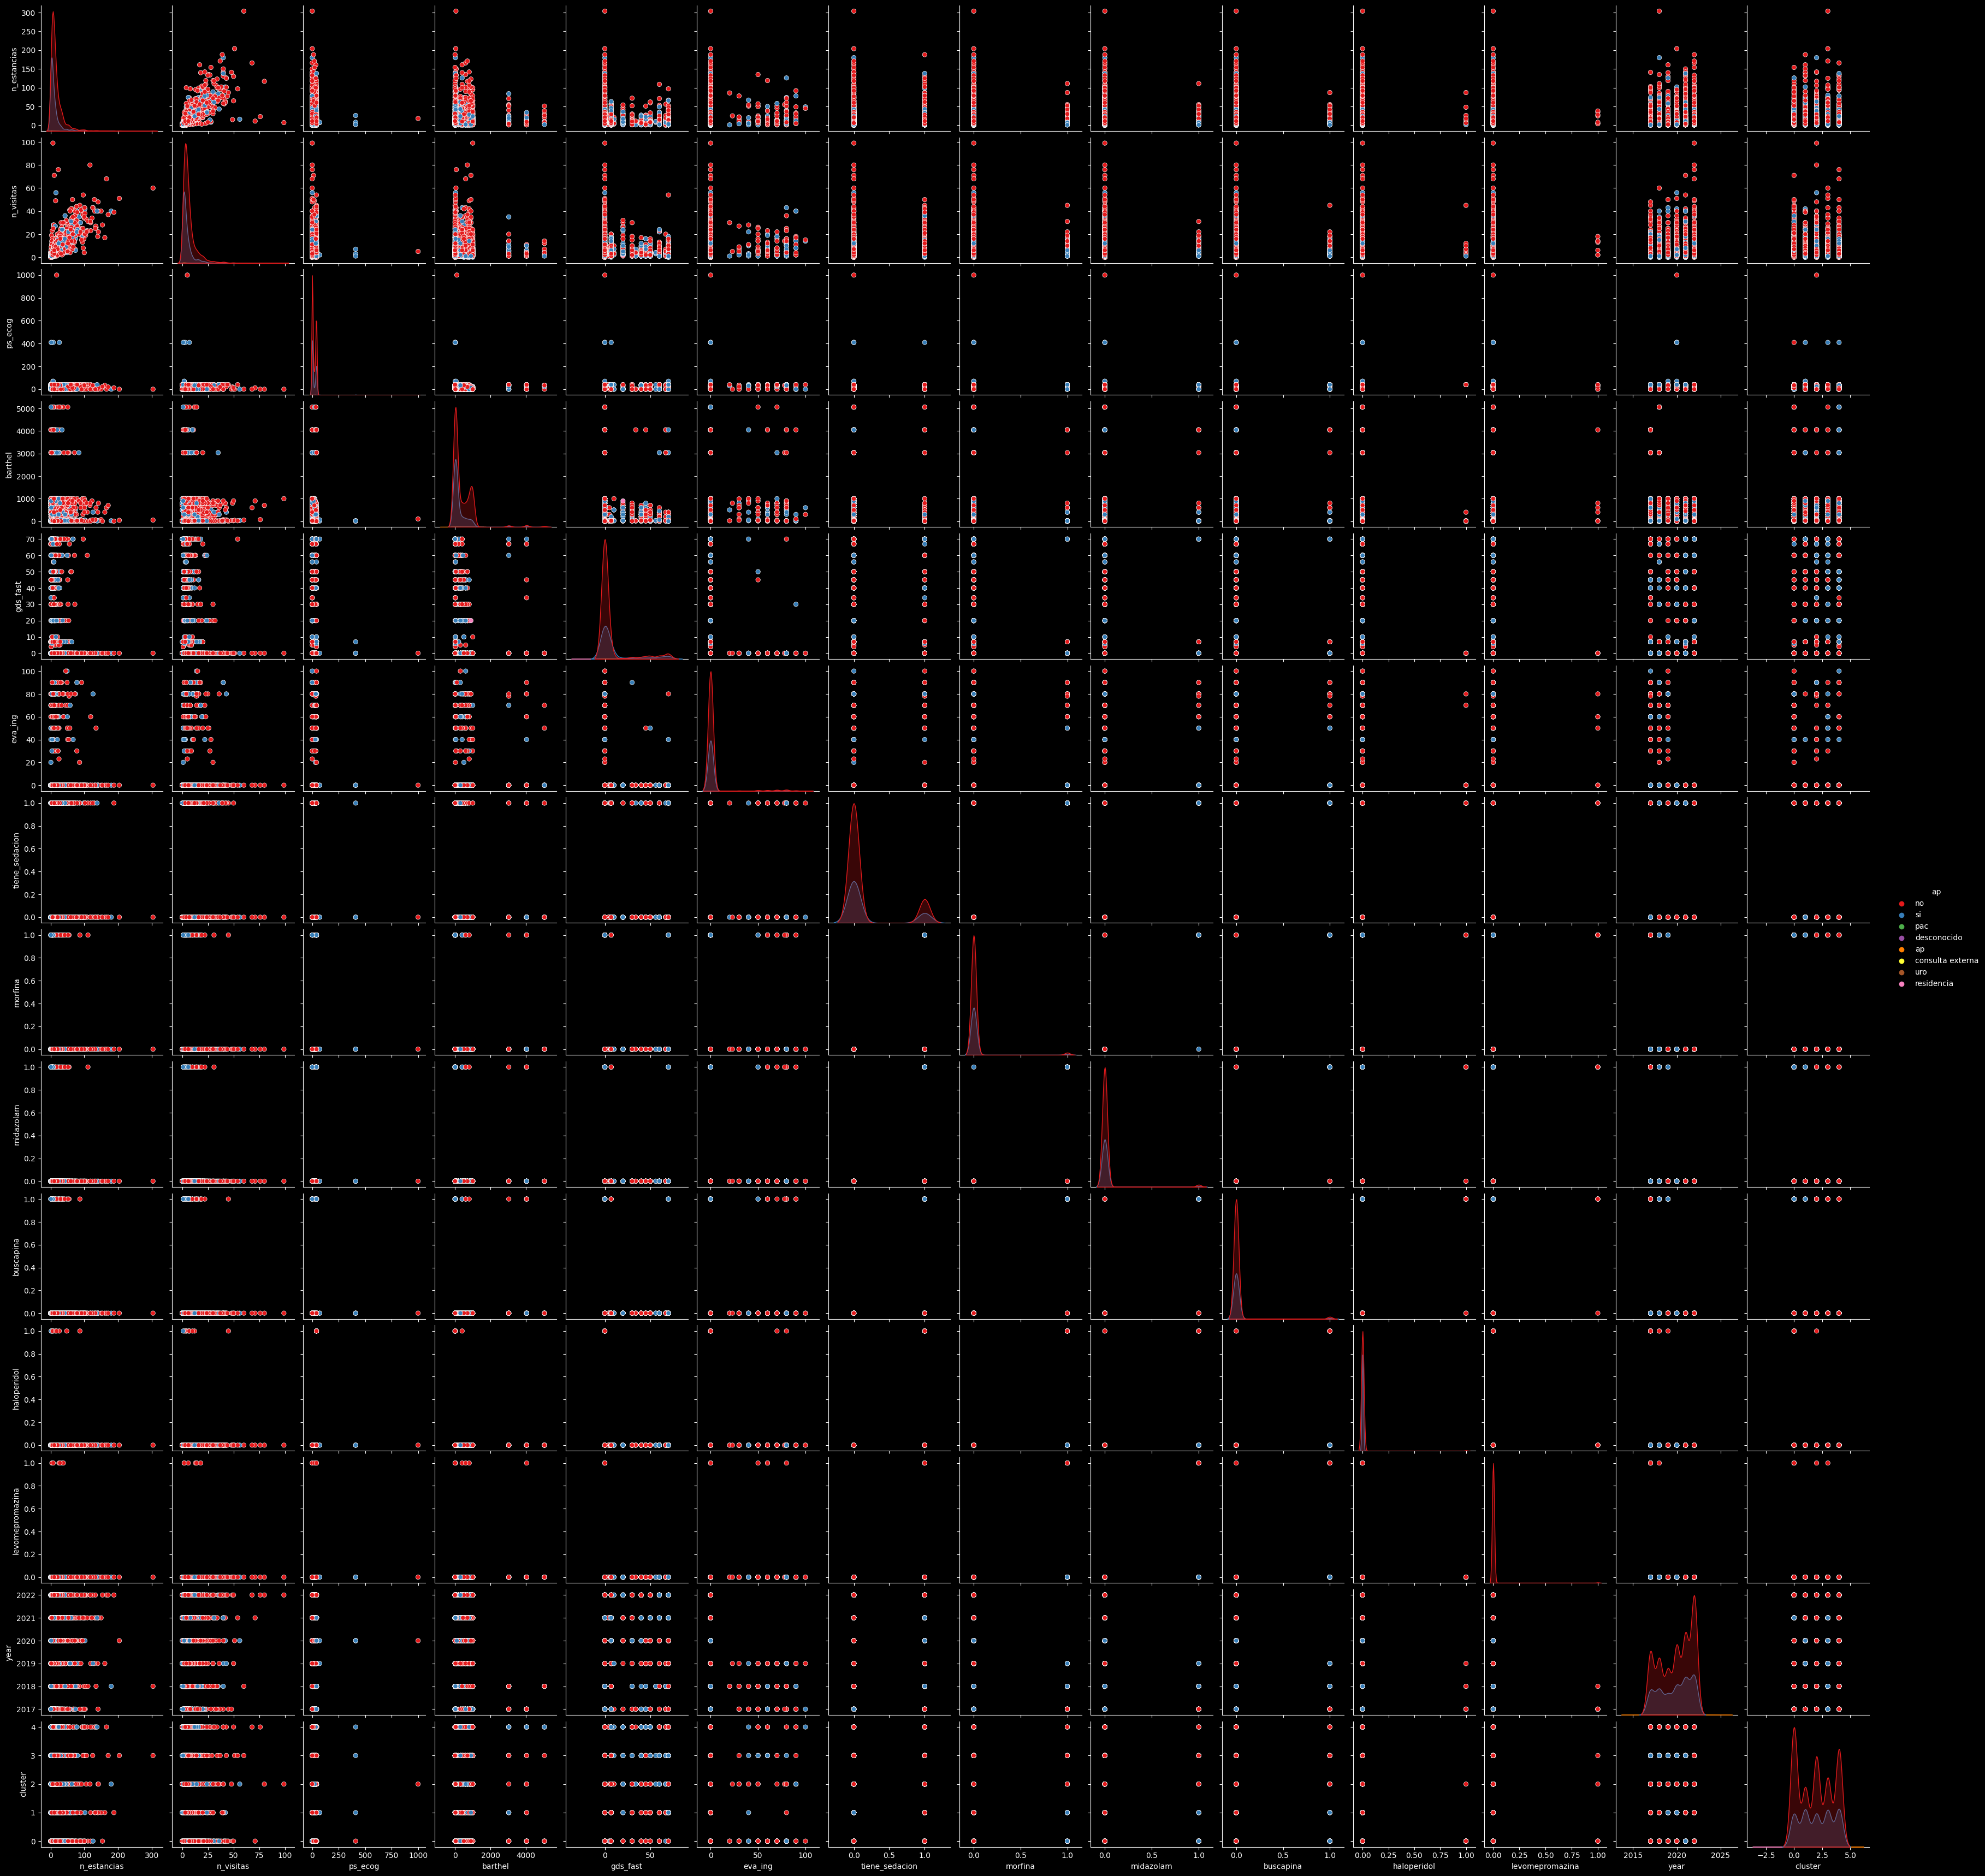

In [148]:
sns.pairplot(data=df_new, hue='ap', palette='Set1')

<Axes: xlabel='cluster', ylabel='n_visitas'>

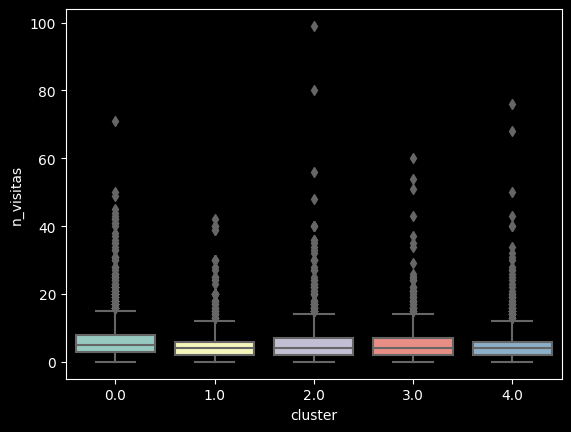

In [146]:
sns.boxplot(x='cluster', y='n_visitas', data=df_new)

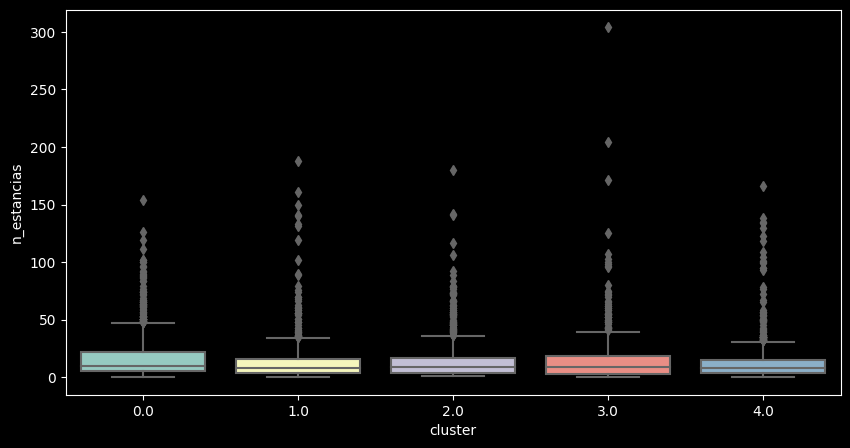

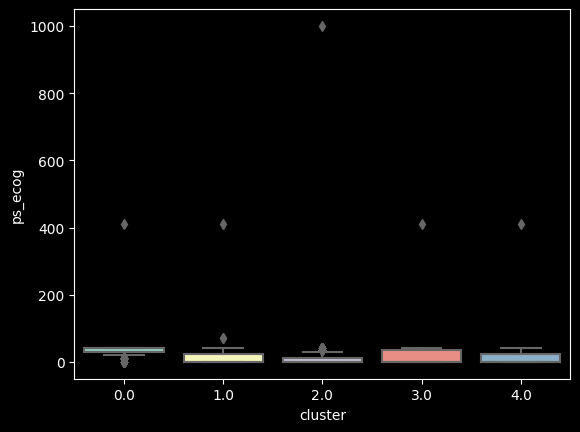

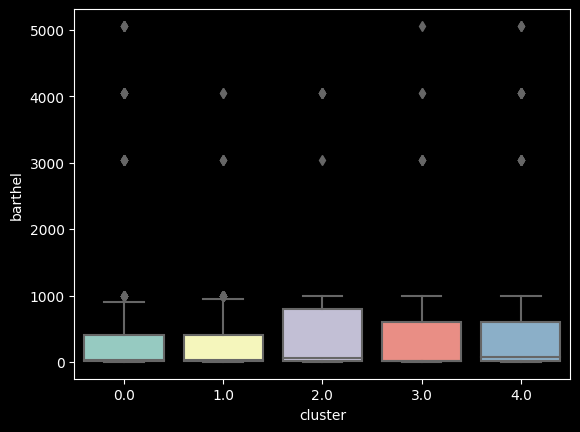

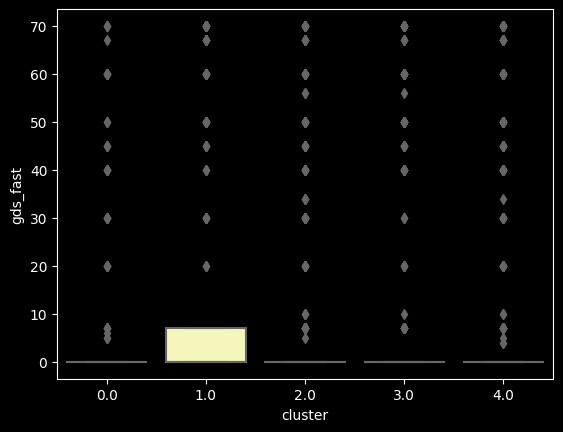

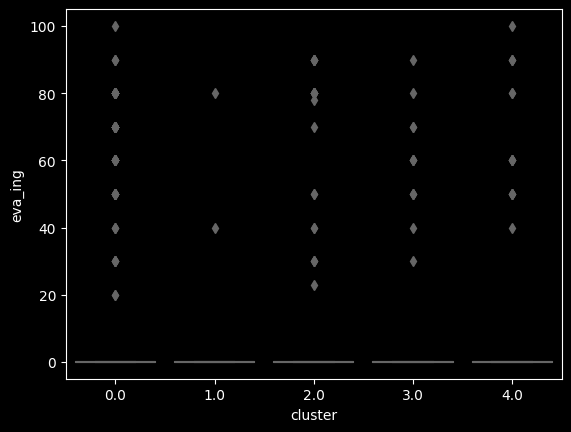

In [149]:
columns_df = ['n_estancias', 'ps_ecog', 'barthel', 'gds_fast', 'eva_ing']
f , ax = plt.subplots(figsize=(10, 5))
for col in columns_df:
    ax = sns.boxplot(x='cluster', y=col, data=df_new, orient='v')
    plt.show()

## 7.1.Análisis de la procedencia

In [150]:
df_new.groupby('cluster')['h_procedencia'].value_counts()

cluster  h_procedencia       
0.0      clinico                 645
         no                      235
         conxo                    63
         gil casares              40
         provincial                2
         residencia                2
         rosaleda                  2
         si                        2
         desconocido               1
         quiron la coruna          1
         san rafael la coruna      1
1.0      clinico                 292
         no                      254
         conxo                    53
         gil casares              32
         chuac                     1
         provincial                1
         residencia                1
2.0      clinico                 476
         no                      229
         conxo                    69
         gil casares              24
         chuac                     2
         lucus augusti             1
         pontevedra                1
         provincial                1
        

In [151]:
df_new.groupby('cluster')['s_procedencia'].value_counts()

cluster  s_procedencia
0.0      oncologia        396
         no               229
         upal              83
         urgencias         61
         mir               44
                         ... 
4.0      mirhp              1
         neurocirugia       1
         neurologia         1
         psqg               1
         urgencias acv      1
Name: s_procedencia, Length: 236, dtype: int64

## 7.2.Análisis del motivo de ingreso por cluster

In [152]:
df_new.groupby('cluster')['motivo_ing'].value_counts()

cluster  motivo_ing                          
0.0      control sintomas                        648
         cuidados paliativos                      30
         continuacion cuidados                    17
         valoracion                               14
         seguimiento                              13
                                                ... 
4.0      valoracion transafusion                   1
         valoracion tratamiento encefalopatia      1
         valoracion ulceras                        1
         valoracion upp                            1
         vigilancia evolutiva                      1
Name: motivo_ing, Length: 806, dtype: int64

## 7.3.Análisis de la duración de la estancia (n_estancias) por cluster

In [154]:
df_new.groupby('cluster')['n_estancias'].describe().T

cluster,0.0,1.0,2.0,3.0,4.0
count,994.000000,634.000000,805.000000,691.000000,888.000000
mean,17.078471,14.700315,14.647205,14.882779,13.207207
std,19.188992,20.589306,18.358502,21.907034,17.690496
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,5.000000,4.000000,4.000000,3.000000,4.000000
50%,10.000000,8.000000,9.000000,9.000000,8.000000
75%,22.000000,16.000000,17.000000,18.000000,15.000000
max,154.000000,188.000000,180.000000,304.000000,166.000000


## 7.4.Análisis del médico asignado (medico) por cluster

In [155]:
df_new.groupby('cluster')['medico'].value_counts()

cluster  medico             
0.0      villar del castillo    221
         galego feal            171
         fernandez benito       145
         suarez                 144
         lopez renedo           102
                               ... 
4.0      valdes                  30
         ibanez alonso           23
         masa                    15
         beceiro                 13
         valcarcel               12
Name: medico, Length: 63, dtype: int64

# 8.Análisis de frecuencia 

## 8.1.Por palabra clave en los diagnósticos

In [156]:
print(len(diagnosticos_split), diagnosticos_split)

1452 [['cancer', 'orl'], ['melanoma', 'vulvar'], ['cancer', 'broncogenico'], ['cirrosis', 'hepatica'], ['neoplasia', 'mama', 'estadio', 'IV'], ['anemia'], ['adenoma', 'pulmon'], ['leucemia', 'linfatica', 'cronica'], ['fx', 'meseta', 'tibial'], ['cancer', 'mama'], ['cancer', 'prostata'], ['deterioro', 'general'], ['tumor', 'cerebral'], ['adenoma', 'colon', 'IV'], ['cancer', 'colon'], ['neumonia'], ['niemannpick'], ['sarcoidosis'], ['cancer', 'pancreas'], ['infeccion', 'urinaria', 'fallo', 'cardiaco'], ['melanoma', 'fosa', 'nasal'], ['cancer', 'timo'], ['infeccion', 'respiratoria'], ['sdown'], ['bocio', 'intratoracico'], ['sepsis', 'respiratoria'], ['intolerancia', 'oral'], ['infeccion', 'urinaria'], ['esclerosis', 'multiple'], ['demencia', 'fallo', 'multiorganico'], ['cancer', 'parotida'], ['ITU'], ['ulceras', 'mmii'], ['smd'], ['cancer', 'colon', 'estadio', 'IV'], ['fractura', 'cadera'], ['fallo', 'cardiaco'], ['cancer', 'endometrio'], ['cancer', 'suprarrenal'], ['amputacion'], ['fract

In [158]:
# Concatena todas las listas de palabras en una sola lista
all_words = [word for sublist in diagnosticos_split for word in sublist]

# Cuenta la frecuencia de cada palabra
word_freq = Counter(all_words)

# Muestra las 10 palabras más comunes
most_common_words = word_freq.most_common(10)
most_common_words

[('cancer', 196),
 ('IV', 146),
 ('estadio', 137),
 ('infeccion', 103),
 ('insuficiencia', 73),
 ('neoplasia', 63),
 ('cardiaca', 52),
 ('cronica', 50),
 ('colon', 46),
 ('respiratoria', 46)]

## 8.2.Análisis de n-gramas

In [160]:
# Genera bigramas
bigrams = list(ngrams(all_words, 2))

# Cuenta la frecuencia de cada bigrama
bigram_freq = Counter(bigrams)

# Muestra los 10 bigramas más comunes
most_common_bigrams = bigram_freq.most_common(10)
most_common_bigrams

[(('estadio', 'IV'), 121),
 (('insuficiencia', 'cardiaca'), 51),
 (('infeccion', 'respiratoria'), 31),
 (('deterioro', 'cognitivo'), 29),
 (('cardiaca', 'cronica'), 27),
 (('IV', 'cancer'), 23),
 (('cancer', 'colon'), 17),
 (('cancer', 'epidermoide'), 17),
 (('pulmon', 'estadio'), 16),
 (('cognitivo', 'severo'), 16)]

In [161]:
# Genera bigramas
trigrams = list(ngrams(all_words, 3))

# Cuenta la frecuencia de cada bigrama
trigram_freq = Counter(trigrams)

# Muestra los 10 bigramas más comunes
most_common_trigrams = trigram_freq.most_common(10)
most_common_trigrams

[(('insuficiencia', 'cardiaca', 'cronica'), 27),
 (('estadio', 'IV', 'cancer'), 19),
 (('pulmon', 'estadio', 'IV'), 15),
 (('colon', 'estadio', 'IV'), 13),
 (('deterioro', 'cognitivo', 'severo'), 11),
 (('prostata', 'estadio', 'IV'), 9),
 (('cancer', 'colon', 'estadio'), 7),
 (('estadio', 'IV', 'neoplasia'), 7),
 (('recto', 'estadio', 'IV'), 7),
 (('estadio', 'IV', 'infeccion'), 7)]

Estos análisis nos permiten ver cuáles son los diagnósticos más comunes entre los pacientes

# 9.Análisis de tendencias a lo largo del tiempo

In [166]:
diagnostic_counts = df_new.groupby(['year', 'diagnostico']).size()
print(diagnostic_counts.info(),"\n", diagnostic_counts.sort_values(ascending=False),"\n")
# print(df_new.groupby(['year', 'diagnostico']).size().sort_values(ascending=False),"\n")

<class 'pandas.core.series.Series'>
MultiIndex: 1944 entries, (2017, 'ITU') to (2022, 'vmi insuficiencia respiratoria')
Series name: None
Non-Null Count  Dtype
--------------  -----
1944 non-null   int64
dtypes: int64(1)
memory usage: 32.4+ KB
None 
 year  diagnostico                   
2022  ITU                               67
      infeccion respiratoria            50
      insuficiencia cardiaca cronica    47
      infeccion urinaria                43
2020  ITU                               40
                                        ..
2019  sindrome anciano fragil            1
      sind hallerman sterif              1
      shock septico                      1
      sepsis urinaria                    1
2022  vmi insuficiencia respiratoria     1
Length: 1944, dtype: int64 



## 9.2.Visualización de las tendencias

In [167]:
import plotly.graph_objects as go

def visualize_diagnostics_by_year_plotly(df, top_n=5):
    """
    Visualize the evolution of main diagnoses by year using an interactive line chart with Plotly.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing diagnostic data with a 'year' column.
    - top_diagnoses (list): The list of top diagnoses to visualize.
    
    Returns:
    None. Displays an interactive line chart showing the evolution of main diagnoses by year.
    """
    
    # Ensure 'year' column is in datetime format
    df['year'] = pd.to_datetime(df['year'], format="%Y")
    
    # Group and unstack data
    diagnosis_by_year = df.groupby(['year', 'diagnostico']).size().unstack('diagnostico')
    
    
    diagnostic_counts = df['diagnostico'].value_counts()
    top_diagnoses = diagnostic_counts.index[:top_n]
    
    # Create the interactive line chart
    fig = go.Figure()
    
    for diagnosis in top_diagnoses:
        fig.add_trace(go.Scatter(x=diagnosis_by_year.index, 
                                 y=diagnosis_by_year[diagnosis],
                                 mode='lines+markers',
                                 name=diagnosis,
                                 marker=dict(size=10, line=dict(width=2)),
                                 line=dict(width=4)))
    
    # Update the layout
    fig.update_layout(
        title="Evolution of Main Diagnoses by Year",
        xaxis_title="Year",
        yaxis_title="Frequency",
        font=dict(size=15),
        legend_title_text='Diagnosis',
        legend=dict(font=dict(size=12))
    )
    
    # Show the plot
    fig.show()

# For demonstration, visualize data using the sample data
# Note: This won't display here, but will work in a local environment.
visualize_diagnostics_by_year_plotly(df, top_n=4)


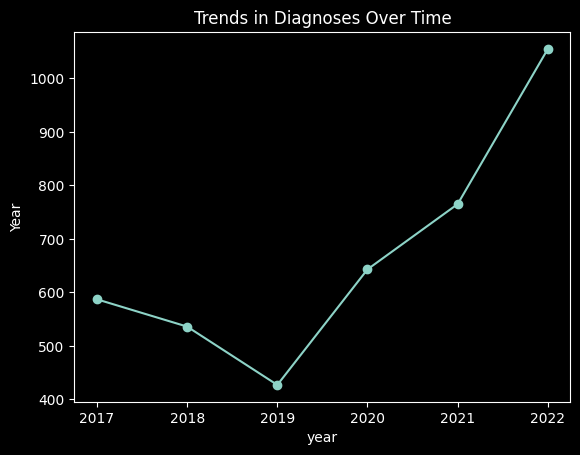

In [168]:
year_counts = df_new.groupby('year').size()
year_counts.plot(kind='line', marker="o")
plt.ylabel('Count')
plt.ylabel('Year')
plt.title('Trends in Diagnoses Over Time')
plt.show()

Al tener muchos diagnósticos distintos clasificaremos por los grupos de palabras más frecuentes en los diagnósticos

## 9.3.Top palabras mas comunes y bigramas

In [183]:
# lista de palabras o bigramas a seguir
common_words = ['cancer', 'ulcera', 'ITU', 'infeccion', 'insuficiencia']  
common_bigrams = [('estadio', 'IV'), ('insuficiencia', 'cardiaca'), ('infeccion', 'tracto')]

In [184]:
#  nueva columna para las palabras o bigramas comunes

def match_word(x, words):
    for word in words:
        if word in x:
            return word
    return None

def match_bigram(x, bigrams):
    words = x.split()
    for i in range(len(words) - 1):
        if (words[i], words[i+1]) in bigrams:
            return (words[i], words[i+1])
    return None

df_new['common_word'] = df_new['diagnostico'].apply(lambda x: match_word(x, common_words))
df_new['common_bigram'] = df_new['diagnostico'].apply(lambda x: match_bigram(x, common_bigrams))


In [185]:
pd.get_dummies(df_new, columns=['common_word', 'common_bigram'])

,h_procedencia,hospital_category,s_procedencia,procedencia_category,diagnostico,diagnosis_category,motivo_ing,ingreso_category,motivo_alta,alta_category,...,"common_bigram_('infeccion', 'tracto')","common_bigram_('insuficiencia', 'cardiaca')",common_word_ITU,common_word_cancer,common_word_infeccion,common_word_insuficiencia,common_word_ulcera,"common_bigram_('estadio', 'IV')","common_bigram_('infeccion', 'tracto')","common_bigram_('insuficiencia', 'cardiaca')"
0,gil casares,Santiago,upal,Unidad Paliativos,cancer orl,Canceres y neoplasias,control sintomas,Sintomas,reingreso,Complicaciones,...,0,0,0,1,0,0,0,0,0,0
1,clinico,Santiago,oncologia,Oncologia,melanoma vulvar,Neurologicas,mal control dolor,Sintomas,exitus,Exitus,...,0,0,0,0,0,0,0,0,0,0
2,clinico,Santiago,mir,MIR,cancer broncogenico,Canceres y neoplasias,control evolutivo,Evaluaciones,fin cuidados,Otros,...,0,0,0,1,0,0,0,0,0,0
3,clinico,Santiago,digestivo,Digestivo,cirrosis hepatica,Hepaticas y pancreaticas,administracion octreotido,Otros,fin cuidados,Otros,...,0,0,0,0,0,0,0,0,0,0
4,clinico,Santiago,urgencias,Urgencias,neoplasia mama estadio IV,Canceres y neoplasias,control sintomas,Sintomas,exitus,Exitus,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4008,clinico,Santiago,oncologia,Oncologia,cancer mama estadio IV,Canceres y neoplasias,control sintomas,Sintomas,exitus,Exitus,...,0,0,0,1,0,0,0,1,0,0
4009,clinico,Santiago,mir,MIR,anciano fragil,Otros,seguimiento,Evaluaciones,exitus,Exitus,...,0,0,0,0,0,0,0,0,0,0
4010,clinico,Santiago,mir,MIR,oclusion intestinal,Otros,cuidados paliativos avanzados,Otros,paso urgencias,Otros,...,0,0,0,0,0,0,0,0,0,0
4011,clinico,Santiago,urgencias,Urgencias,ITU,Otros,antibioterapia IV,Tratamientos,exitus,Exitus,...,0,0,1,0,0,0,0,0,0,0


## 9.4.One-hot encoding de las nuevas columnas

In [186]:
# One-hot encoding de las nuevas columnas

df_new = pd.get_dummies(df_new, columns=['common_word', 'common_bigram'])


In [187]:
# Agrupo por año y sumo las columnas
word_counts = df_new.filter(regex='common_word').groupby(df_new['year']).sum()
bigram_counts = df_new.filter(regex='common_bigram').groupby(df_new['year']).sum()
print(word_counts)
print(bigram_counts)

      common_word_cancer  common_word_infeccion  common_word_insuficiencia  \
year                                                                         
2017                 145                     59                         17   
2018                 141                     45                         24   
2019                 115                     30                         18   
2020                 127                     58                         43   
2021                 142                     61                         44   
2022                 137                    135                         74   

      common_word_respiratorio  common_word_ulcera  common_word_cancer  \
year                                                                     
2017                         0                  20                 145   
2018                         1                   7                 141   
2019                         0                  12                 115   
2020 

## 9.5.Visualización de las tendencias

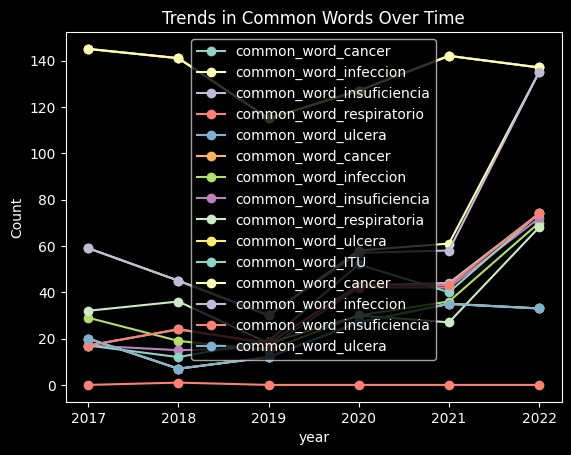

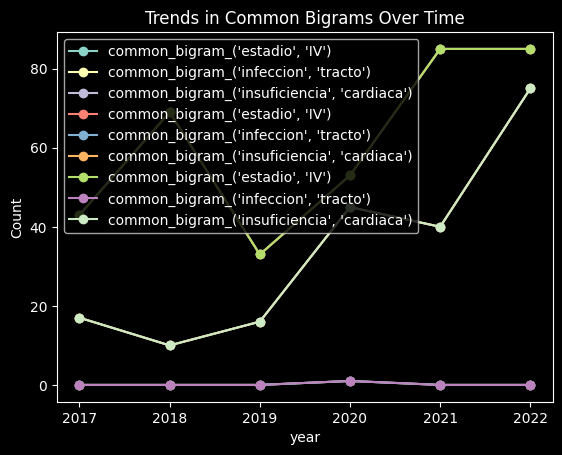

In [188]:
word_counts.plot(kind='line', marker="o")
plt.ylabel('Count')
plt.title('Trends in Common Words Over Time')
plt.show()

bigram_counts.plot(kind='line', marker="o")
plt.ylabel('Count')
plt.title('Trends in Common Bigrams Over Time')
plt.show()


# Otros...

* Análisis de grupos: Podrías realizar un análisis más profundo de cada grupo. Por ejemplo, podrías examinar las características de los pacientes dentro de cada grupo para ver si hay alguna característica que distinga a los pacientes en un grupo de los pacientes en otro grupo.

* Análisis de tendencias a lo largo del tiempo: Si tienes datos de tiempo, podrías examinar cómo han cambiado los diagnósticos a lo largo del tiempo. ¿Han aumentado o disminuido ciertos diagnósticos? ¿Ha habido cambios en los grupos de diagnósticos a lo largo del tiempo?

* Predecir diagnósticos: Si tienes un objetivo específico, como predecir un cierto diagnóstico basándote en las características de un paciente, podrías entrenar un modelo de aprendizaje automático supervisado utilizando tus vectores de diagnósticos como entrada.

* Análisis de sentimiento: Si tus diagnósticos incluyen texto escrito por médicos o pacientes, podrías considerar realizar un análisis de sentimiento para entender mejor cómo se sienten los pacientes o cómo perciben su condición.

* Pruebas de correlación: Podrías realizar pruebas de correlación entre diferentes variables para ver si hay alguna relación entre, por ejemplo, la edad de un paciente y el tipo de diagnóstico que recibe.

Preprocesamiento de los datos:
    
    Codificación de Frecuencias: En este método, reemplazas cada categoría de la variable por la frecuencia con la que aparece en el conjunto de datos. Por ejemplo, si la categoría 'resfriado común' aparece 100 veces en la variable 'diagnóstico', entonces reemplazas 'resfriado común' por 100. Aquí te dejo un ejemplo de cómo hacerlo con pandas:

In [197]:
hado_data = catalog.load('hado_final')

[09/17/23 17:19:13] INFO     Loading data from 'hado_final' (CSVDataSet)...                     data_catalog.py:345

In [198]:
# Creas un mapeo de frecuencias
freq_map = hado_data['diagnostico'].value_counts().to_dict()

# Aplicas el mapeo a la columna 'diagnostico'
hado_data['diagnostico'] = hado_data['diagnostico'].map(freq_map)


In [202]:
print(len(hado_data['diagnostico'].unique()), 
      "\n\n",
      hado_data['diagnostico'].unique())

40 

 [  7   1   4  57   2  28  21   5  12  23  54   6  30 145   3 113  15 173
  11  13   8  16  24  44  17  73  34  27  58   9  70  39  10  18  26  33
  42  22  14  69]


Codificación de Target

In [203]:

X = hado_data.select_dtypes(exclude='object')
y = hado_data['diagnostico']
# Asegúrate de dividir tus datos en conjuntos de entrenamiento y prueba primero
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplica la codificación al conjunto de entrenamiento
target_enc = ce.TargetEncoder(cols=['diagnostico']).fit(X_train, y_train)

# Transforma tus conjuntos de datos
X_train = target_enc.transform(X_train)
X_test = target_enc.transform(X_test)

Paso 2: Selección de Características

Una vez que hayas convertido estas variables a formatos numéricos, puedes utilizar todas las demás variables como características para predecir la variable 'diagnostico'. También puedes realizar una selección de características para determinar cuáles son las más importantes para tu modelo.

* **Eliminación Recursiva de Características (RFE)**: RFE es una técnica que elimina las características una por una, basándose en la importancia de las características calculada por un modelo específico.
````python
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# define el método de selección de características
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)

# ajusta y aplica la transformación
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

````
* **Importancia de la característica basada en el modelo**: Algunos modelos de Machine Learning ofrecen una forma de clasificar las características por importancia.
````python
from sklearn.ensemble import RandomForestClassifier

# define el modelo
model = RandomForestClassifier()

# entrena el modelo
model.fit(X_train, y_train)

# obtén la importancia de las características
importance = model.feature_importances_

# resume la importancia de las características
for i,j in enumerate(importance):
    print('Característica: %0d, Puntuación: %.5f' % (i,j))
````

* **Correlación de Pearson**: La correlación de Pearson mide la dependencia lineal entre dos variables. Podemos usarla para seleccionar las características más correlacionadas con la variable objetivo.

````python
# calcula la correlación de Pearson de las características con la variable objetivo
correlations = df.corrwith(df['diagnostico']).iloc[:-1].to_frame()
correlations['abs'] = correlations[0].abs()

# imprime las características más correlacionadas
top_features = correlations.sort_values('abs', ascending=False)[0]
print(top_features)
````


Paso 3: Creación y Entrenamiento del Modelo

Como mencioné anteriormente, puedes probar varios modelos como el árbol de decisión, bosque aleatorio, SVM, KNN y la regresión logística multiclase. Aquí te dejo un ejemplo de cómo hacerlo con un modelo de bosque aleatorio:

In [204]:
from sklearn.ensemble import RandomForestClassifier

# Crea el modelo
model = RandomForestClassifier()

# Entrena el modelo
model.fit(X_train, y_train)

RandomForestClassifier()

Paso 4: Evaluación del Modelo

Para evaluar tu modelo, puedes utilizar la precisión, recall, F1-score, ROC-AUC, etc. También puedes utilizar una matriz de confusión para ver cómo se comporta tu modelo en cada una de las clases:

In [205]:
# Haz predicciones en tu conjunto de prueba
y_pred = model.predict(X_test)

# Imprime el informe de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       238
           2       0.95      1.00      0.97        58
           3       0.77      0.86      0.81        42
           4       0.54      0.56      0.55        25
           5       0.75      0.64      0.69        33
           6       0.12      0.08      0.10        13
           7       0.59      0.62      0.61        16
           8       0.30      0.40      0.34        15
           9       0.18      0.22      0.20         9
          10       0.40      0.22      0.29         9
          11       0.25      0.20      0.22         5
          12       1.00      0.29      0.44         7
          13       0.47      0.39      0.42        18
          14       0.25      0.50      0.33         2
          15       0.17      0.20      0.18         5
          16       0.29      0.31      0.30        13
          17       0.21      0.33      0.26         9
          18       0.00    